In [6]:
from exact_diagonalization import * 

In [5]:
from qiskit import *
from qiskit.quantum_info import random_statevector, Statevector, partial_trace, entropy, random_unitary
import numpy as np
from numpy import sin, cos, exp, sort, trace, sqrt, arange, pi, log, log2
from numpy.linalg import norm, eig
import matplotlib as mpl
import matplotlib.pyplot as plt
from qiskit.providers.aer import AerSimulator
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_state_city
from qiskit.providers.aer.noise import amplitude_damping_error, phase_damping_error, NoiseModel
from qiskit_experiments.library import StateTomography
mpl.rcParams['figure.dpi']= 200
from math import floor, e
from qiskit.opflow import Z

sx, sy, sz = np.array([[0,1],[1,0]]), np.array([[0,-1j],[1j,0]]), np.array([[1,0],[0,-1]])
s = np.array([sx, sy, sz])

C:\Users\alepa\AppData\Local\Temp\ipykernel_22912\3883178384.py:14: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import Z


Exercise 1: 

proof: P is doubly stochastic. done. 

### Exercise 2

In [42]:
def Bell(i,j):
    ### takes phase and parity and outputs a circuit which outputs the 
    ### corresponding bell state
    
    qc = QuantumCircuit(2)
    
    if i == 1:
        qc.x(0)
    if j == 1:
        qc.x(1)
    
    qc.h(0)
    qc.cx(0,1)
    return qc

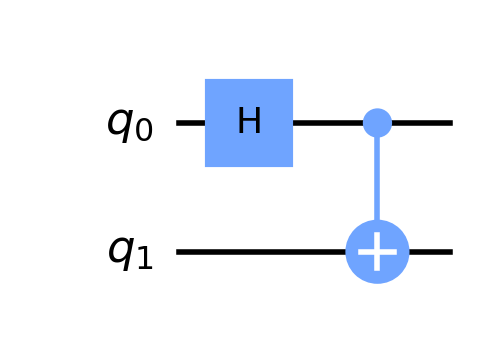

In [43]:
### draw the Bell circuits
Bell(0,0).draw('mpl')

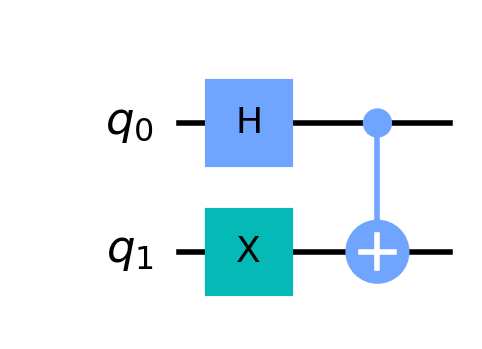

In [44]:
Bell(0,1).draw('mpl')

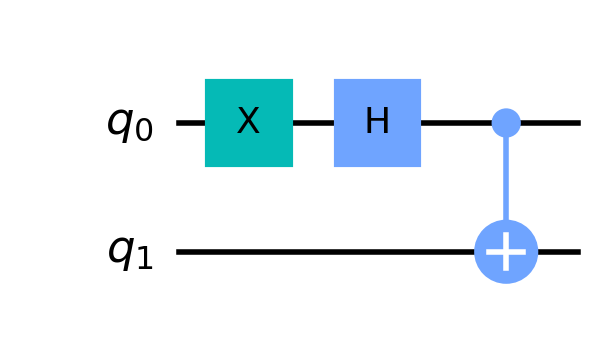

In [45]:
Bell(1,0).draw('mpl')

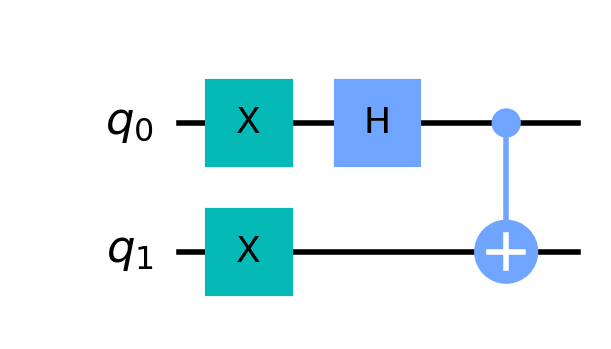

In [46]:
Bell(1,1).draw('mpl')

### Exercise 3

In [5]:
def teleport(statevector):
    a = QuantumRegister(2, name = "a")
    b = QuantumRegister(1, name = "b")
    c = ClassicalRegister(2, name = "c")
    qc = QuantumCircuit(a,b,c)
    
    ### sample Alice's state
    qc.initialize(statevector,0)
    
    ### Create Bell state on Alice's 1 and Bob's qubit
    qc.h(a[1])
    qc.cx(a[1], b[0])
    qc.barrier()
    
    ### Bell measurement
    qc.cx(a[0],a[1])
    qc.h(a[0])
    qc.barrier()
    
    ### Conditional operations
    qc.measure(a,c)
    qc.z(b).c_if(c[0], 1)
    qc.x(b).c_if(c[1], 1)
    return qc

In [6]:
### random state to be teleported
sv = random_statevector(2)

### teleportation circuit
circ = teleport(sv)

### here we want statevector simulator. 
backend = Aer.get_backend("statevector_simulator")

res = execute(circ, backend, shots = 1).result().get_statevector()

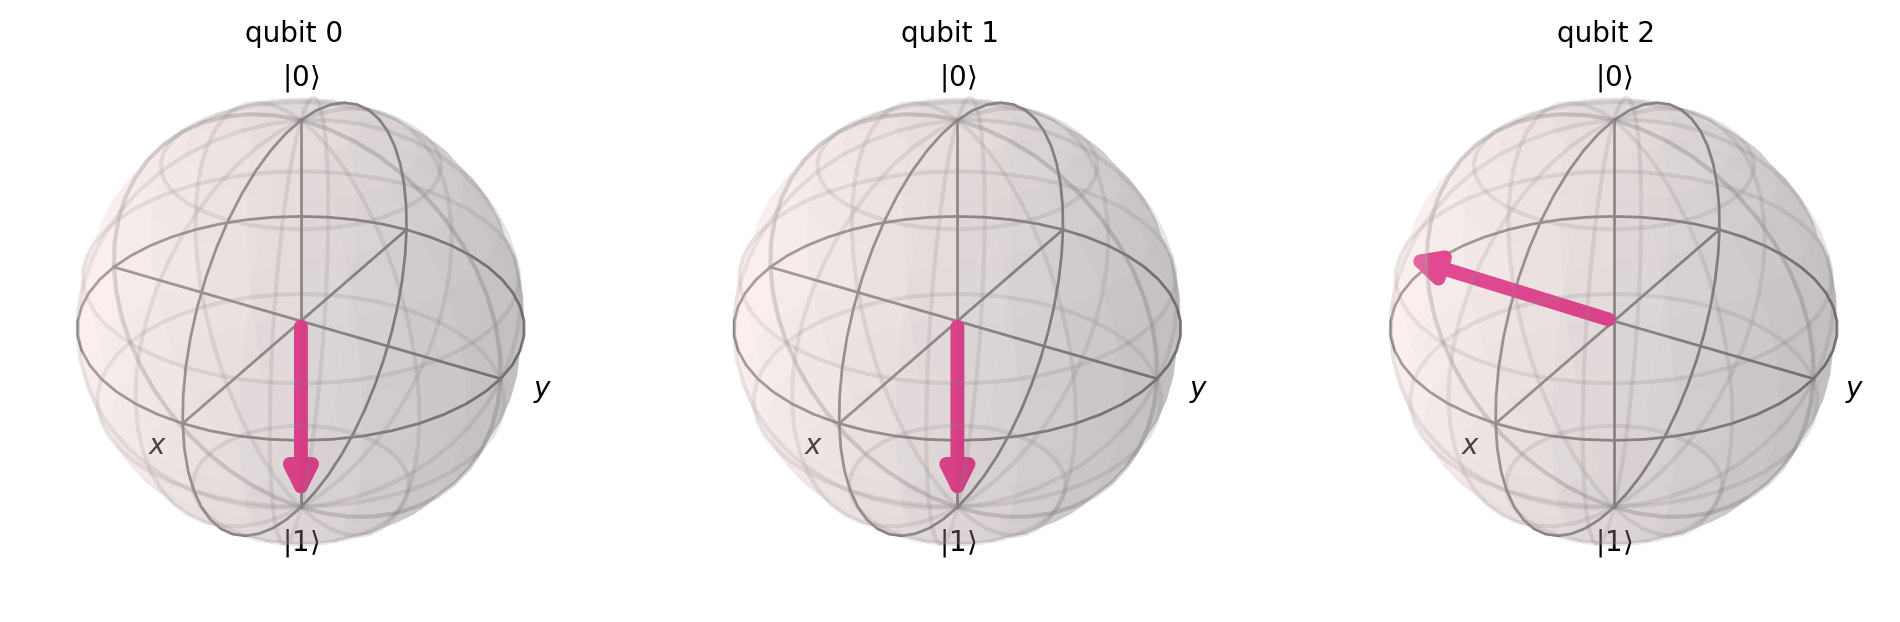

In [7]:
plot_bloch_multivector(res)

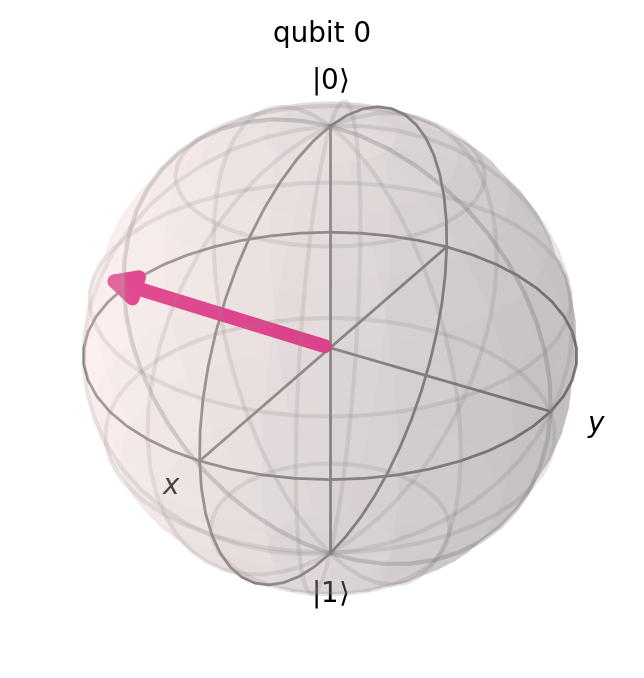

In [8]:
plot_bloch_multivector(sv)

### Exercise 5

In [10]:
def time_evolve(circ, t, dt, w, w0, w1):
    
    def step(circ, T_c):
        circ.rz(-1 * w0 * dt,0)
        circ.rx(2 * dt * w1 * cos(w * T_c),0)
        return circ
    
    times = arange(0, t, dt)
    
    qc = circ
    
    for i in range(len(times)):
        qc = step(qc, times[i])
    
    qc.measure(0,0)
    
    return qc

#### a)

In [10]:
w1 = 2
w0 = 25
w = 25.5
dt = 0.05
backend = Aer.get_backend("qasm_simulator")

def population(t):
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    circ = QuantumCircuit(q,c)
    
    counts = execute(time_evolve(circ,t, dt, w, w0, w1), backend, shots = 400).result().get_counts()
    return counts.get("1", 0)/400

def analytical(t):
    Omega = sqrt(w1**2 + (w-w0)**2)
    return w1**2/Omega**2 * (sin(Omega * t/2))**2

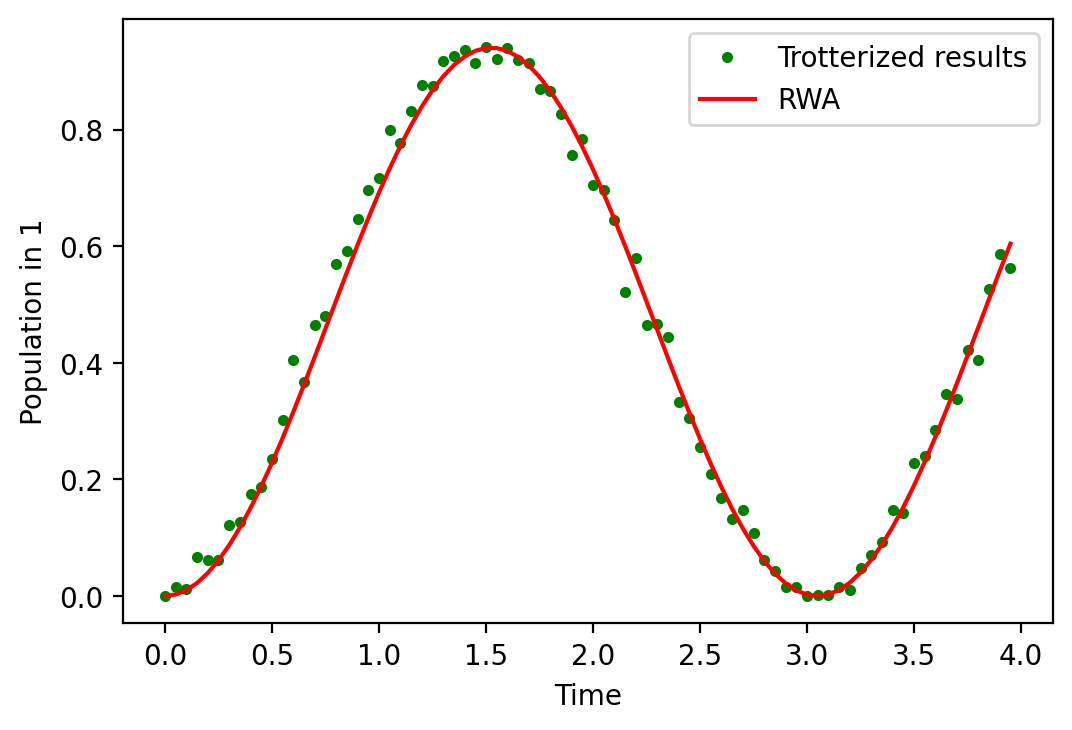

In [11]:
plt.plot(arange(0,4,0.05), [population(0.05 * i) for i in range(80)], "g.", label = "Trotterized results")
plt.plot(arange(0,4,0.05), [analytical(0.05 * i) for i in range(80)], "r-", label = "RWA")
plt.xlabel("Time")
plt.ylabel("Population in 1")
plt.legend()
plt.show()

#### b)

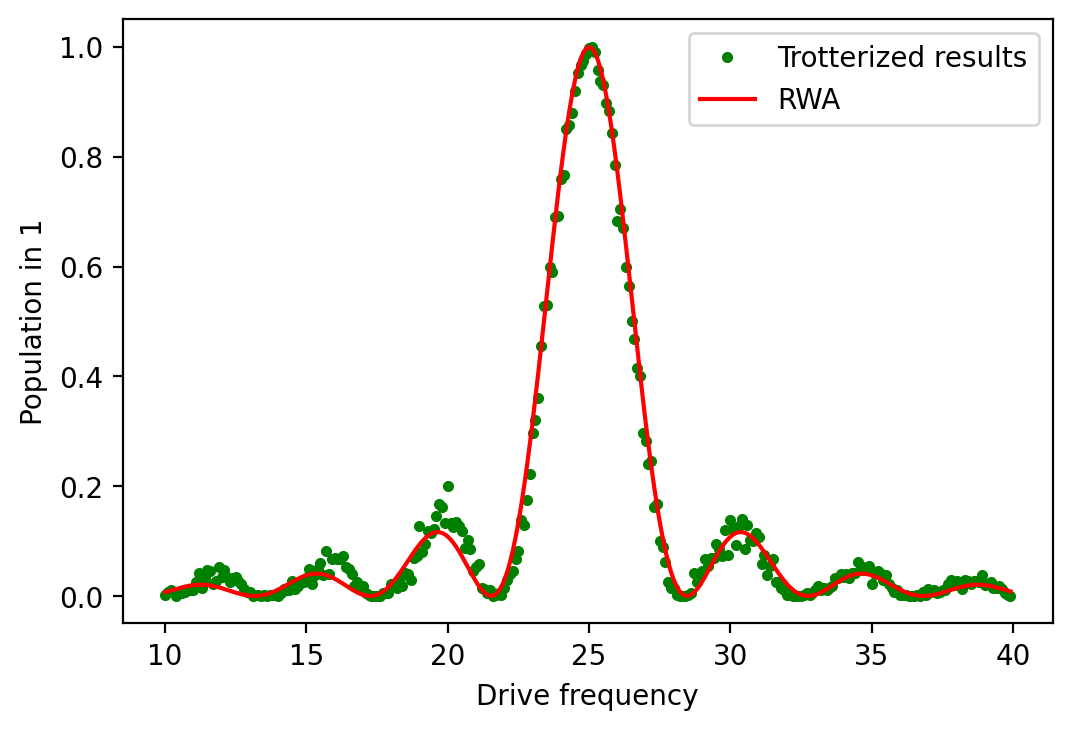

In [12]:
t = pi/w1

def population_b(drive_freq):
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    circ = QuantumCircuit(q,c)
    
    counts = execute(time_evolve(circ,t, dt, drive_freq, w0, w1), backend, shots = 400).result().get_counts()
    return counts.get("1", 0)/400

def analytical_b(drive_freq):
    Omega = sqrt(w1**2 + (drive_freq - w0)**2)
    return w1**2/Omega**2 * (sin(Omega * t/2))**2

plt.plot(arange(10,40,0.1), [population_b(10 + 0.1 * i) for i in range(300)], "g.", label = "Trotterized results")
plt.plot(arange(10,40,0.1), [analytical_b(10 + 0.1 * i) for i in range(300)], "r-", label = "RWA")
plt.xlabel("Drive frequency")
plt.ylabel("Population in 1")
plt.legend()
plt.show()

#### c)

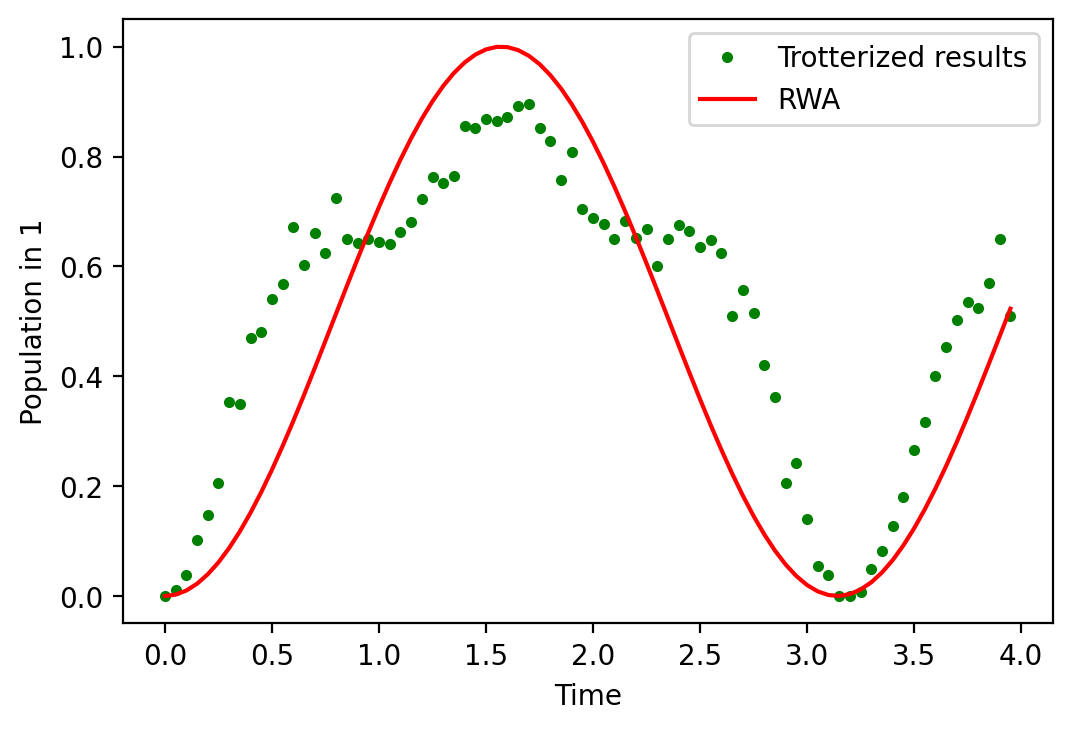

In [13]:
w = w1 = w0 = 2
plt.plot(arange(0,4,0.05), [population(0.05 * i) for i in range(80)], "g.", label = "Trotterized results")
plt.plot(arange(0,4,0.05), [analytical(0.05 * i) for i in range(80)], "r-", label = "RWA")
plt.xlabel("Time")
plt.ylabel("Population in 1")
plt.legend()
plt.show()

RWA assumes drive field frequency is high. Here it's not. 

### Exercise 6

In [18]:
### redefine global parameters 

gamma = 0.02
p = 0.1
w1 = 2
w0 = 25
w = 25.5
t = 5
dt = 0.05

error = amplitude_damping_error(gamma, p)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error, ["rz","rx"])
simulator = AerSimulator(noise_model = noise_model)


def noisy_population(t, noise_model):
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    circ = QuantumCircuit(q,c)

    counts = simulator.run(time_evolve(circ,t, dt, w, w0, w1), 
                     shots = 2000).result().get_counts()
    
    return counts.get("1", 0)/2000

dt2=0.01
def noisy_population2(t, noise_model):
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    circ = QuantumCircuit(q,c)
    
    counts = simulator.run(time_evolve(circ,t, dt2, w, w0, w1), 
                     shots = 400).result().get_counts()
    
    return counts.get("1", 0)/400

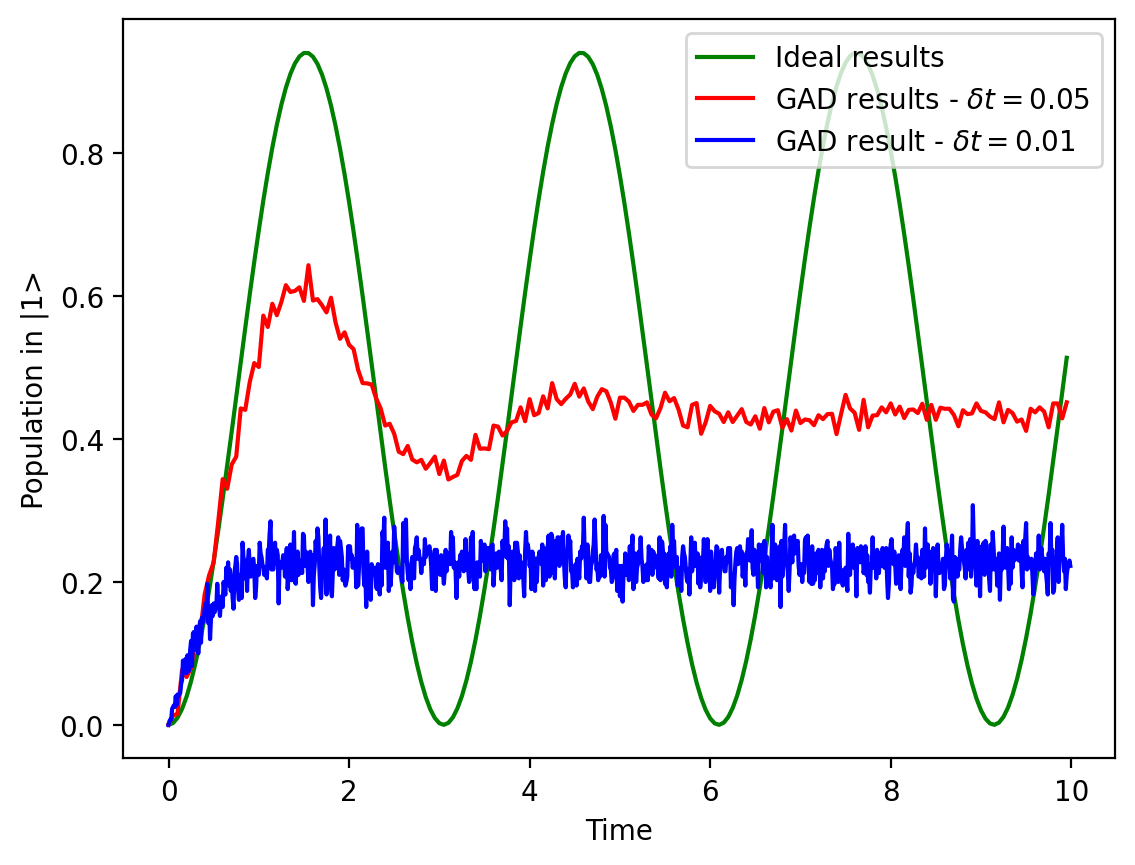

In [20]:
backend = Aer.get_backend("qasm_simulator")
plt.plot(arange(0,10,0.05), [analytical(0.05 * i) for i in range(200)], "g-", label = "Ideal results")
plt.plot(arange(0,10,0.05), [noisy_population(0.05 * i, noise_model) for i in range(200)], "r-", label = "GAD results - " + r"$\delta t = 0.05$")

#probably need to change noise model
plt.plot(arange(0,10,0.01), [noisy_population2(0.01 * i, noise_model) for i in range(1000)], "b-", label = "GAD result - " + r"$\delta t = 0.01$")

plt.xlabel("Time")
plt.ylabel("Population in |1>")
plt.legend()
plt.show()

### Exercise 7

In [12]:
from qiskit.providers.fake_provider import FakeVigo

In [13]:
w1 = 2
w0 = 25
w = 25.5
dt = 0.05
backend = FakeVigo()

def population(t):
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    circ = QuantumCircuit(q,c)
    
    counts = execute(time_evolve(circ,t, dt, w, w0, w1), backend, shots = 400).result().get_counts()
    return counts.get("1", 0)/400

def analytical(t):
    Omega = sqrt(w1**2 + (w-w0)**2)
    return w1**2/Omega**2 * (sin(Omega * t/2))**2

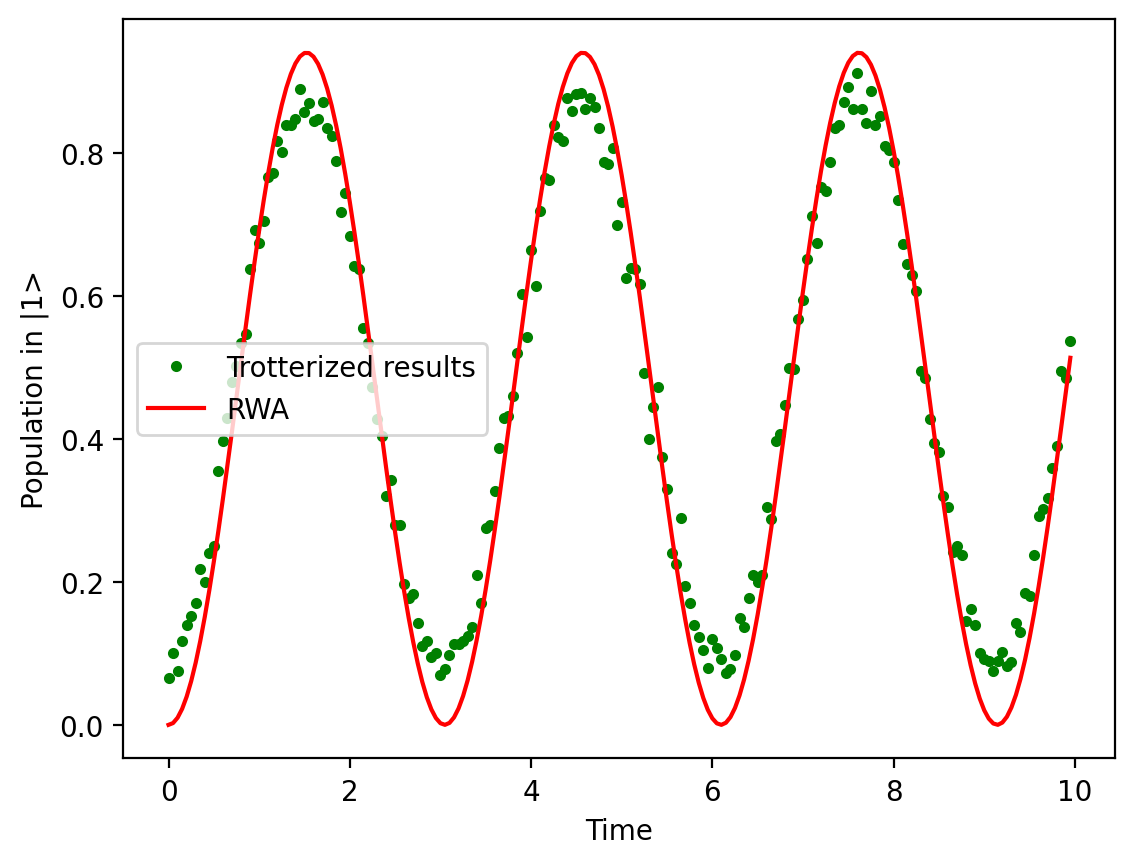

In [14]:
plt.plot(arange(0,10,0.05), [population(0.05 * i) for i in range(200)], "g.", label = "Trotterized results")
plt.plot(arange(0,10,0.05), [analytical(0.05 * i) for i in range(200)], "r-", label = "RWA")
plt.xlabel("Time")
plt.ylabel("Population in |1>")
plt.legend()
#plt.savefig('Rabi_fake_vigo')
plt.show()

### Exercise 8

In [17]:
backend = Aer.get_backend("qasm_simulator")
def expect_z(circ):
    qc = circ
    qc.measure_all()
    counts = execute(qc, backend, shots = 1000).result().get_counts()
    return (counts.get("0", 0) - counts.get("1", 0))/1000

def expect_x(circ):
    qc = circ
    qc.h(0)
    qc.measure_all()
    counts = execute(qc, backend, shots = 1000).result().get_counts()
    return (counts.get("0", 0) - counts.get("1", 0))/1000

def expect_y(circ):
    qc = circ
    qc.rx(pi/2, 0)
    qc.measure_all()
    counts = execute(qc, backend, shots = 1000).result().get_counts()
    return (counts.get("0", 0) - counts.get("1", 0))/1000

### Exercise 9

In [18]:
def T_state():
    qc = QuantumCircuit(1)
    qc.h(0)
    qc.t(0)
    return qc

### unitary circuit generating the state T instead. 

def reconstruct(state):
    c_x, c_y, c_z = [expect_x(state()), expect_y(state()), expect_z(state())]
    bv = [c_x, c_y, c_z]
    bv /= norm(bv)
    return 1/2 * (np.identity(2) + np.einsum("i,ijk", bv, s))

In [19]:
acc = np.array([reconstruct(T_state) for i in range(100)])
acc = 1/100 * np.sum(acc, axis = 0)

In [20]:
experiment = StateTomography(T_state())
data = experiment.run(backend, seed_simulation = 100).block_for_results()
q_rho = np.matrix(data.analysis_results("state").value)

In [21]:
#### trace distance of our state tomography results for 100 iterations 
### compared to qiskit's for 100. 
D = np.matrix(acc - q_rho)
1/2 * sqrt(np.trace(D.H @ D).real)

0.008707487185665377

### Problem 10

In [18]:
w1 = 2
w0 = 25
w = 25.5
dt = 0.05

def tomo(t):
    ### gives density matrix [1,1] entry for time t of the trotterized time evolution
    q = QuantumRegister(1)
    c = ClassicalRegister(1)
    circ = QuantumCircuit(q,c)
    
    rab = time_evolve(circ, t, dt, w, w0, w1)
    
    experiment = StateTomography(rab)
    data = experiment.run(backend, seed_simulation = 100).block_for_results()
    q_rho = np.matrix(data.analysis_results("state").value)
    return [q_rho[0,0].real, q_rho[1,1].real]



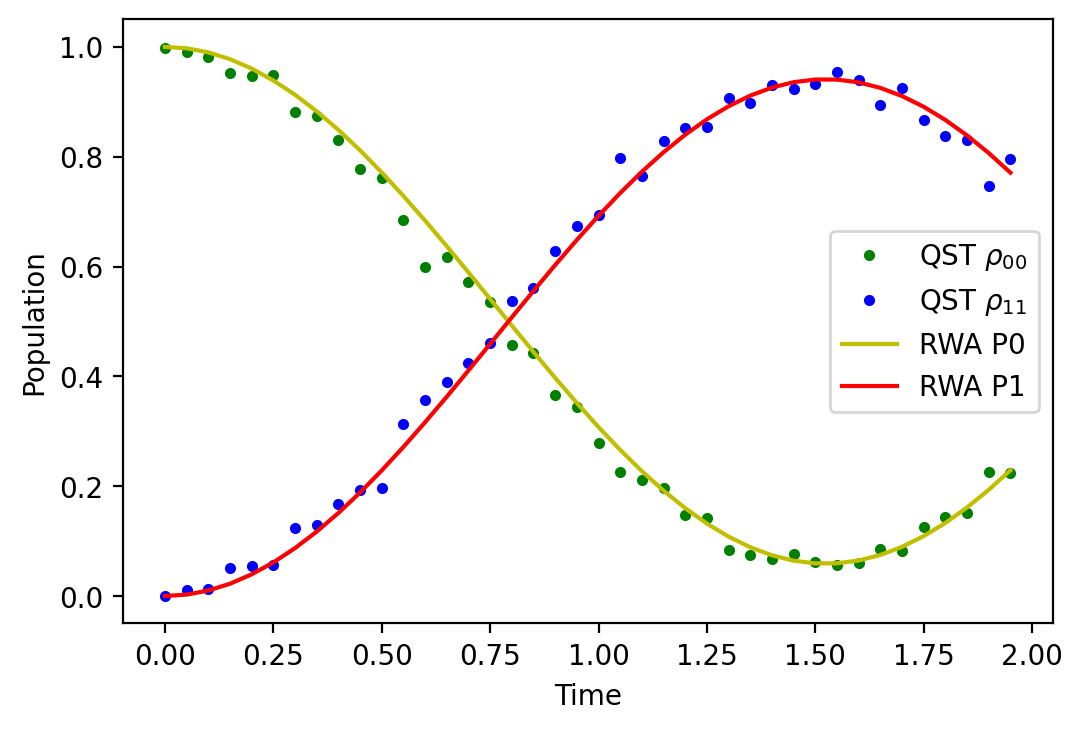

In [20]:
plt.plot(arange(0,2,0.05), np.array([tomo(0.05 * i) for i in range(40)])[:,0], "g.", label = "QST " + r"$\rho_{00}$")
plt.plot(arange(0,2,0.05), np.array([tomo(0.05 * i) for i in range(40)])[:,1], "b.", label = "QST " + r"$\rho_{11}$")
plt.plot(arange(0,2,0.05), [1-analytical(0.05 * i) for i in range(40)], "y-", label = "RWA P0")
plt.plot(arange(0,2,0.05), [analytical(0.05 * i) for i in range(40)], "r-", label = "RWA P1")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.show()

### Problem 11

In [25]:
def PQC(a,b):
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.rzz(-2 * b, 0, 1)
    qc.h(0)
    qc.barrier()
    qc.h(1)
    qc.rzz(-2 * b, 0, 1)
    qc.h(1)
    qc.barrier()
    qc.rz(-2 * a, 0)
    qc.rz(-2 * a, 1)
    return qc

### Problem 12

In [26]:
backend = Aer.get_backend("qasm_simulator")

In [27]:
def H12_expect(qc):
    
    def string1(qc):
        psi = qc.copy()
        psi.h(0)
        psi.measure_all()
        counts = execute(psi, backend, shots = 5000).result().get_counts()
        pos = counts.get("00", 0) + counts.get("11", 0)
        neg = counts.get("01", 0) + counts.get("10", 0)
        contribution = 1/5000 * (pos - neg)
        return contribution
    
    def string2(qc):
        psi = qc.copy()
        psi.h(1)
        psi.measure_all()
        counts = execute(psi, backend, shots = 5000).result().get_counts()
        pos = counts.get("00", 0) + counts.get("11", 0)
        neg = counts.get("01", 0) + counts.get("10", 0)
        contribution = 1/5000 * (pos - neg)
        return contribution
    
    return -1 * (string1(qc) + string2(qc))    

In [28]:
a = np.linspace(0,pi,20)
b = np.linspace(0,pi,20)
a,b = np.meshgrid(a,b)

In [29]:
result = np.array([[H12_expect(PQC(a[i][j], b[i][j])) for j in range(20)] for i in range(20)])

In [30]:
### parameters of a and b at the minima
np.unravel_index(np.argmin(result), result.shape)

(14, 14)

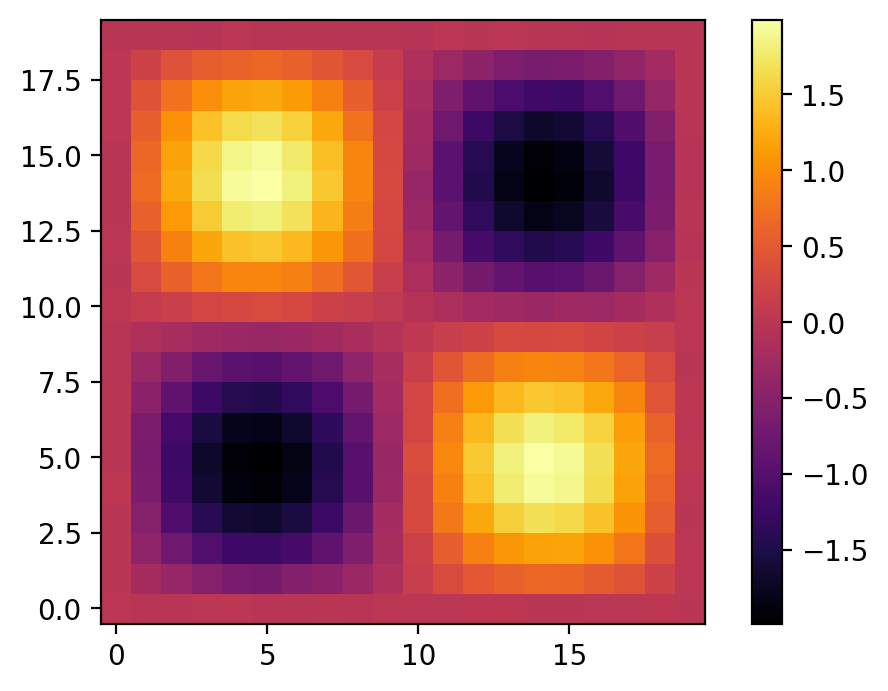

In [31]:
plt.imshow(result, origin = "lower", cmap = "inferno")
cbar = plt.colorbar()
cbar.set_label('Energy')
plt.xlabel("a")
plt.ylabel("b")
plt.show()

### Problem 13

In [32]:
backend = Aer.get_backend("statevector_simulator")
psi_0 = np.matrix(execute(PQC(a[5,5], b[5,5]), backend).result().get_statevector())

psi_true = 1/2 * np.matrix([[1,1,1,-1]])

norm(psi_0.H @ psi_true)

1.0000000000000002

### Problem 14

In [33]:
p = 0.2
gamma = 0.1
error = amplitude_damping_error(gamma, p)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(error, ["rz", "h"])

simulator = AerSimulator(noise_model = noise_model)

def noisy_H12_expect(qc):
    
    def string1(qc):
        psi = qc.copy()
        psi.h(0)
        psi.measure_all()
        counts = simulator.run(psi, shots = 5000).result().get_counts()
        pos = counts.get("00", 0) + counts.get("11", 0)
        neg = counts.get("01", 0) + counts.get("10", 0)
        contribution = 1/5000 * (pos - neg)
        return contribution
    
    def string2(qc):
        psi = qc.copy()
        psi.h(1)
        psi.measure_all()
        counts = simulator.run(psi, shots = 5000).result().get_counts()
        pos = counts.get("00", 0) + counts.get("11", 0)
        neg = counts.get("01", 0) + counts.get("10", 0)
        contribution = 1/5000 * (pos - neg)
        return contribution
    
    return -1 * (string1(qc) + string2(qc))    

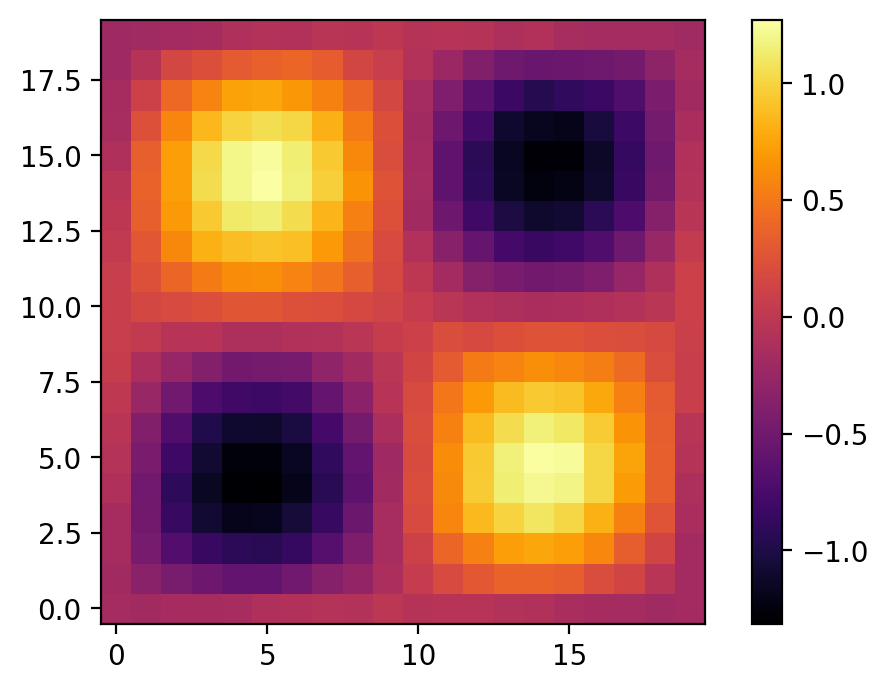

In [34]:
result_noisy = np.array([[noisy_H12_expect(PQC(a[i][j], b[i][j])) for j in range(20)] for i in range(20)])
plt.imshow(result_noisy, origin = "lower", cmap = "inferno")
cbar = plt.colorbar()
cbar.set_label('Energy')
plt.xlabel("a")
plt.ylabel("b")
plt.show()

## Day 2

### Exercise 6

In [22]:
def evolve_basic(circ, g, dt):
    l = circ.num_qubits
    even = [i for i in range(l-1) if i%2 == 0]
    odd = [i for i in range(l-1) if i%2 != 0]

    circ.rx(-g * dt, range(l))
    
    for i in range(len(even)):
        circ.rzz(-1 * dt, even[i], even[i]+1)
        
    for i in range(len(odd)):
        circ.rzz(-1 * dt, odd[i], odd[i] + 1)
    return circ

def evolve_symmetric(circ, g, dt):
    l = circ.num_qubits
    even = [i for i in range(l-1) if i%2 == 0]
    odd = [i for i in range(l-1) if i%2 != 0]

    circ.rx(-g * dt/2, range(l))
    
    for i in range(len(even)):
        circ.rzz(-1 * dt, even[i], even[i]+1)
        
    for i in range(len(odd)):
        circ.rzz(-1 * dt, odd[i], odd[i] + 1)
        
    circ.rx(-g * dt/2, range(l))
    
    return circ

C:\Users\alepa\anaconda3\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


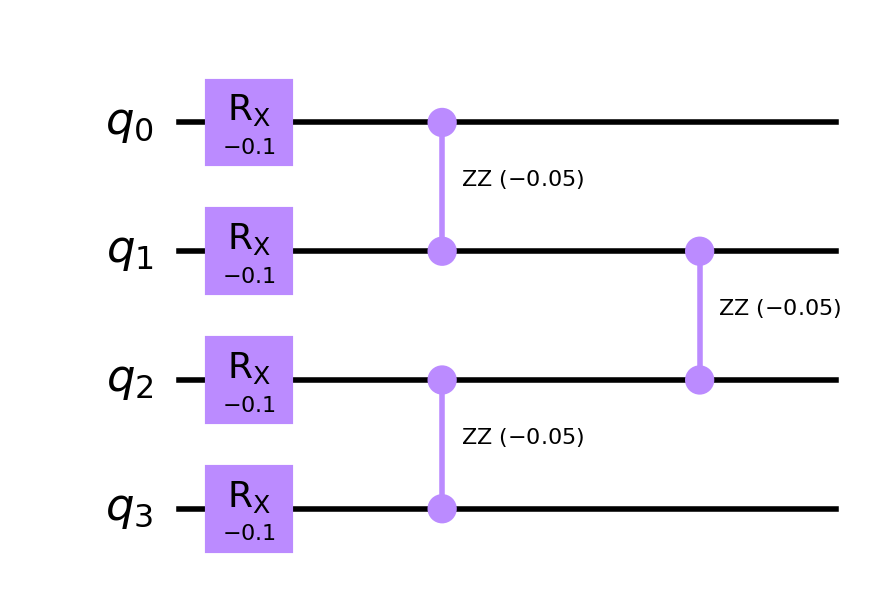

In [25]:
#drawing exemplary circuit
N = 4
t = 5
dt = 0.05
g = 2

qcircuit=QuantumCircuit(N)
qcircuit = evolve_basic(qcircuit, 2, dt)
qcircuit.draw('mpl', filename = 'DQFT_basic')

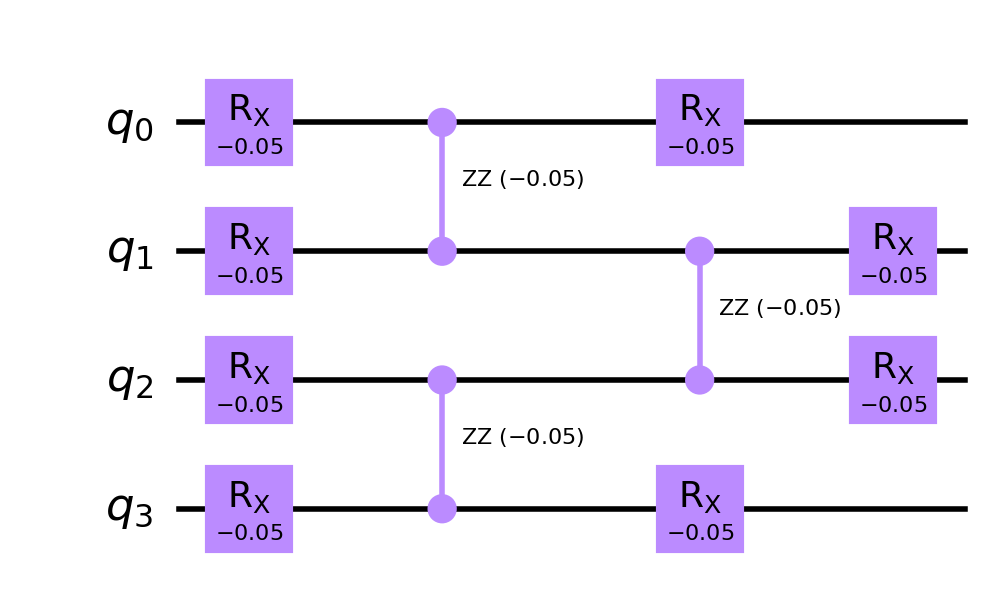

In [26]:
qcircuit=QuantumCircuit(N)
qcircuit = evolve_symmetric(qcircuit, 2, dt)
qcircuit.draw('mpl', filename = 'DQFT_symmetric')

### Exercise 7

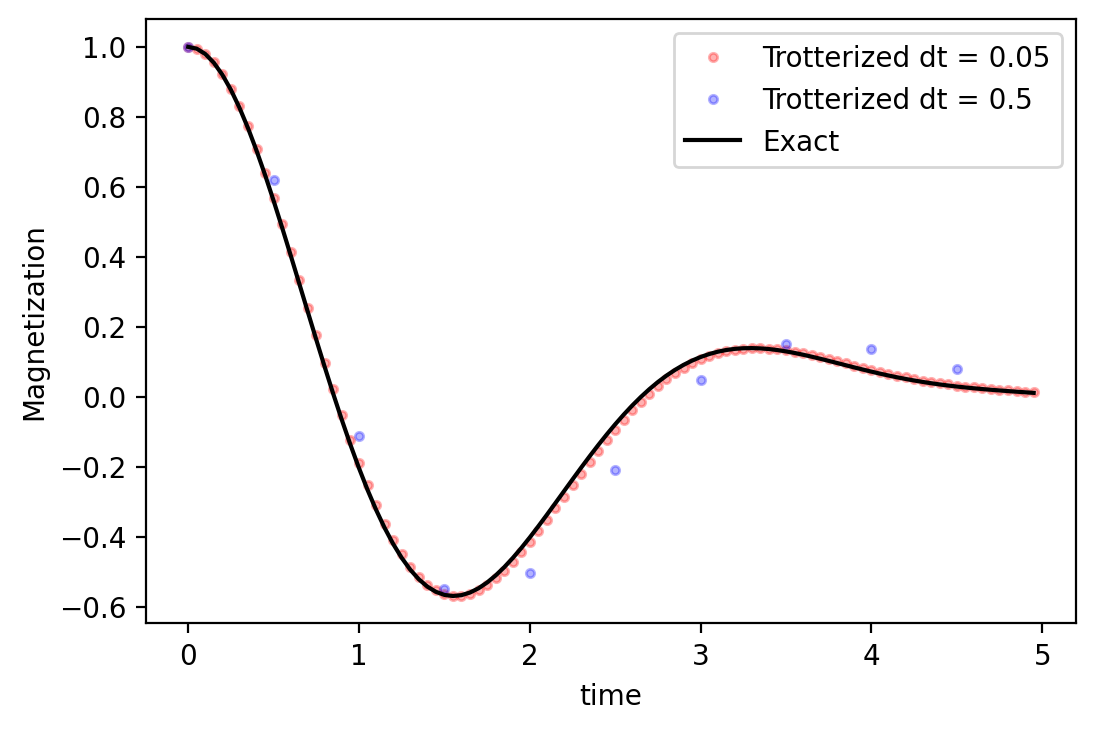

In [36]:
backend = Aer.get_backend("statevector_simulator")

N = 10
t = 5
dt = 0.05

def sim_mag_sv(N, t, dt):
    ### magnetization of psi(t) for psi0 = |0> and the Ising Hamiltonian
    qc = QuantumCircuit(N)
    g = 2
    steps = int(np.rint(t/dt))
    for i in range(steps):
        qc = evolve_symmetric(qc, 2, dt)
    state = execute(qc, backend).result().get_statevector()
    m_z = np.mean(np.array([state.expectation_value(Z, [i]).real for i in range(10)]))
    return m_z

plt.plot(np.arange(0,5,0.05), np.array([sim_mag_sv(10, i * 0.05, 0.05) for i in range(100)]), "r.", alpha = 0.3, label = "Trotterized dt = 0.05")
#plt.plot(np.arange(0,5,0.025), np.array([sim_mag_sv(10, i * 0.025, 0.025) for i in range(200)]), "y-", alpha = 0.3, label = "Trotterized dt = 0.25")
plt.plot(np.arange(0,5,0.5), np.array([sim_mag_sv(10, i * 0.5, 0.5) for i in range(10)]), "b.", alpha = 0.3, label = "Trotterized dt = 0.5")
plt.plot(0.05 * np.array([i for i in range(100)]), magn_exact_diagonalization(10,2,5,100), "k-", alpha = 1, label = "Exact")
plt.xlabel("time")
plt.ylabel("Magnetization")
plt.legend()
plt.show()

### Exercise 8

In [23]:
backend = Aer.get_backend("statevector_simulator")

def l(N, L):
    return - 1/N * log(L)

def sim_loschmidt(N, g, t, dt):
    ### returns L0, L1 for N, t, dt
    qc = QuantumCircuit(N)
    steps = int(np.rint(t/dt))
    for i in range(steps):
        qc = evolve_symmetric(qc, g, dt)
    state = np.array(execute(qc, backend).result().get_statevector())
    L0, L1 = norm(state[0])**2, norm(state[-1])**2
    L = L0 + L1
    return [l(N,L0), l(N,L1), l(N,L)]

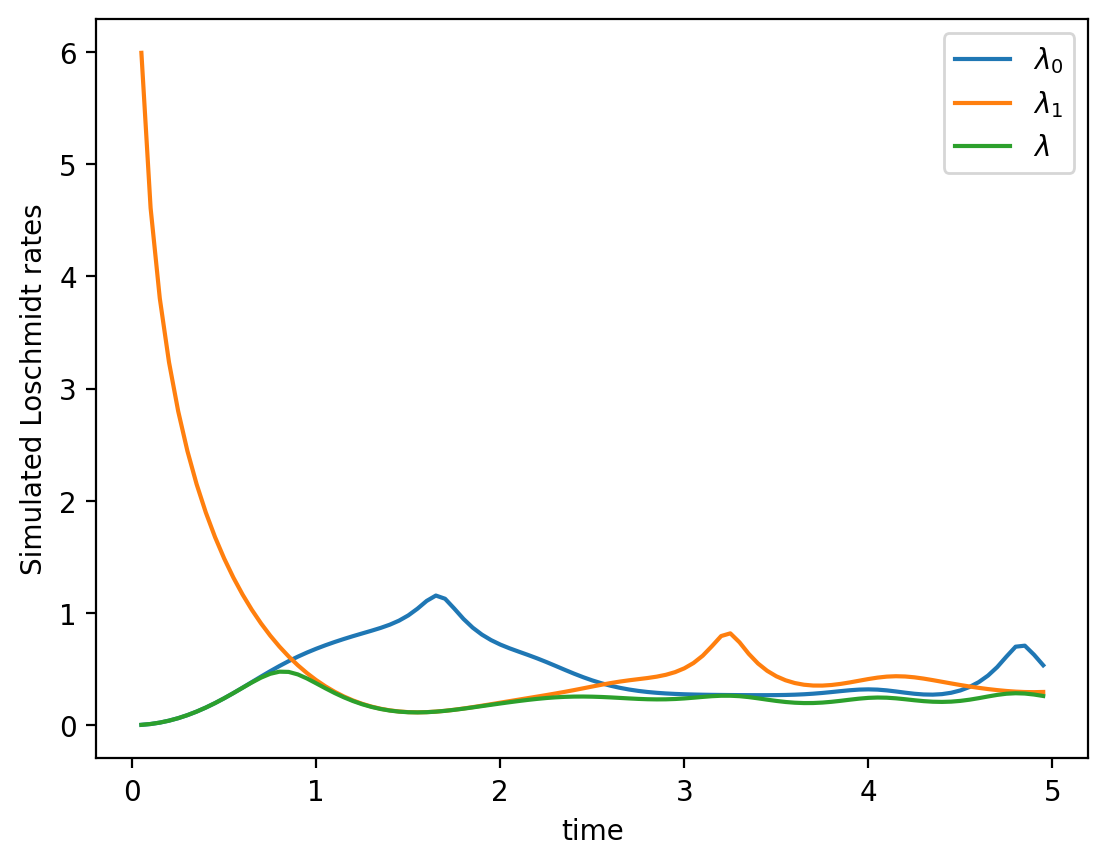

In [24]:
t = arange(0.05,5,0.05)

L_6 = np.array([sim_loschmidt(6,2,i,0.05) for i in t])
plt.plot(t, L_6[:,0], label = r"$\lambda_0$")
plt.plot(t, L_6[:,1], label = r"$\lambda_1$")
plt.plot(t, L_6[:,2], label = r"$\lambda$")
plt.legend()
plt.xlabel("time")
plt.ylabel("Simulated Loschmidt rates")
plt.show()

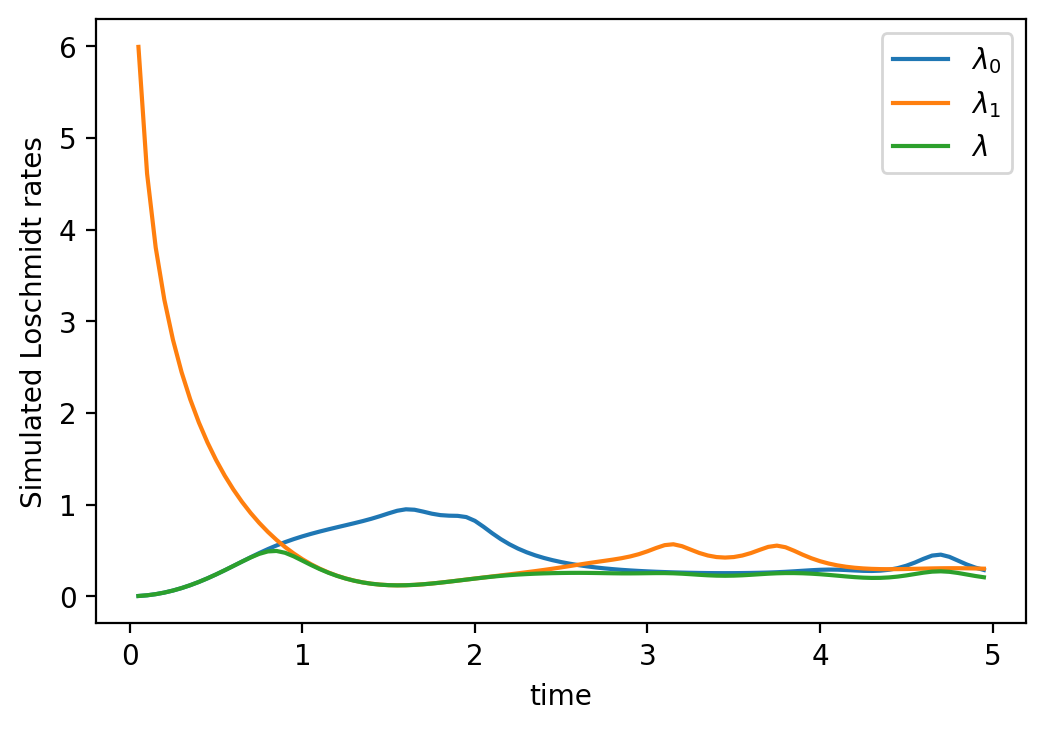

In [39]:
L_8 = np.array([sim_loschmidt(8,2,i,0.05) for i in t])
plt.plot(t, L_8[:,0], label = r"$\lambda_0$")
plt.plot(t, L_8[:,1], label = r"$\lambda_1$")
plt.plot(t, L_8[:,2], label = r"$\lambda$")
plt.legend()
plt.xlabel("time")
plt.ylabel("Simulated Loschmidt rates")
plt.show()

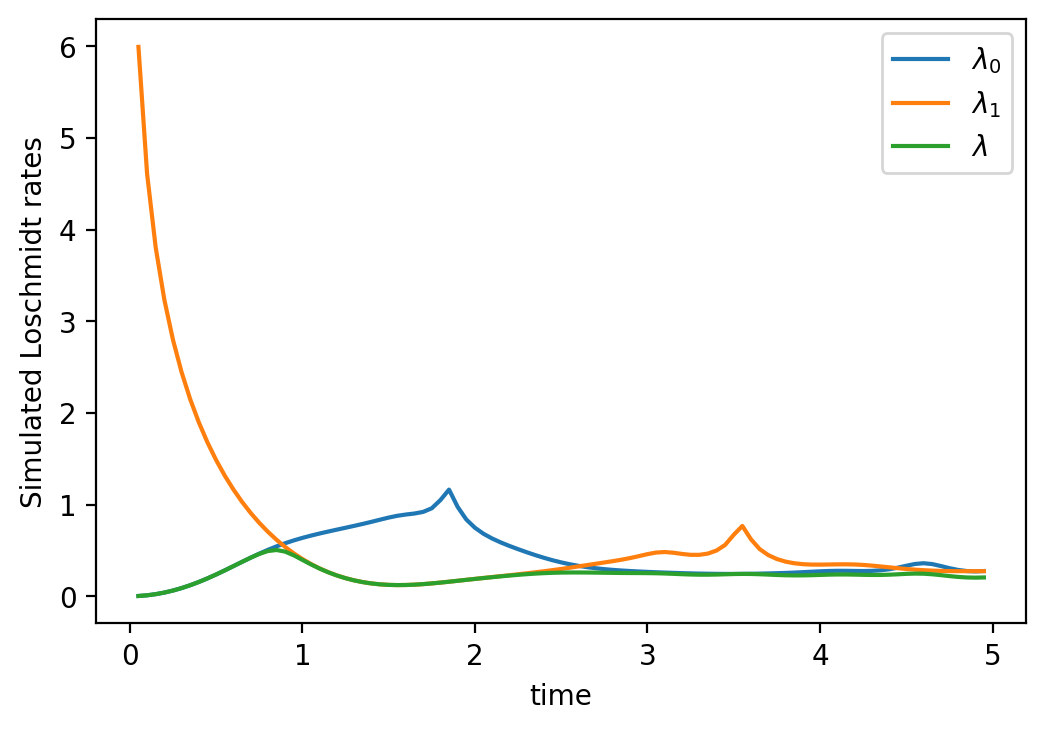

In [40]:
L_10 = np.array([sim_loschmidt(10,2,i,0.05) for i in t])
plt.plot(t, L_10[:,0], label = r"$\lambda_0$")
plt.plot(t, L_10[:,1], label = r"$\lambda_1$")
plt.plot(t, L_10[:,2], label = r"$\lambda$")
plt.legend()
plt.xlabel("time")
plt.ylabel("Simulated Loschmidt rates")
plt.show()

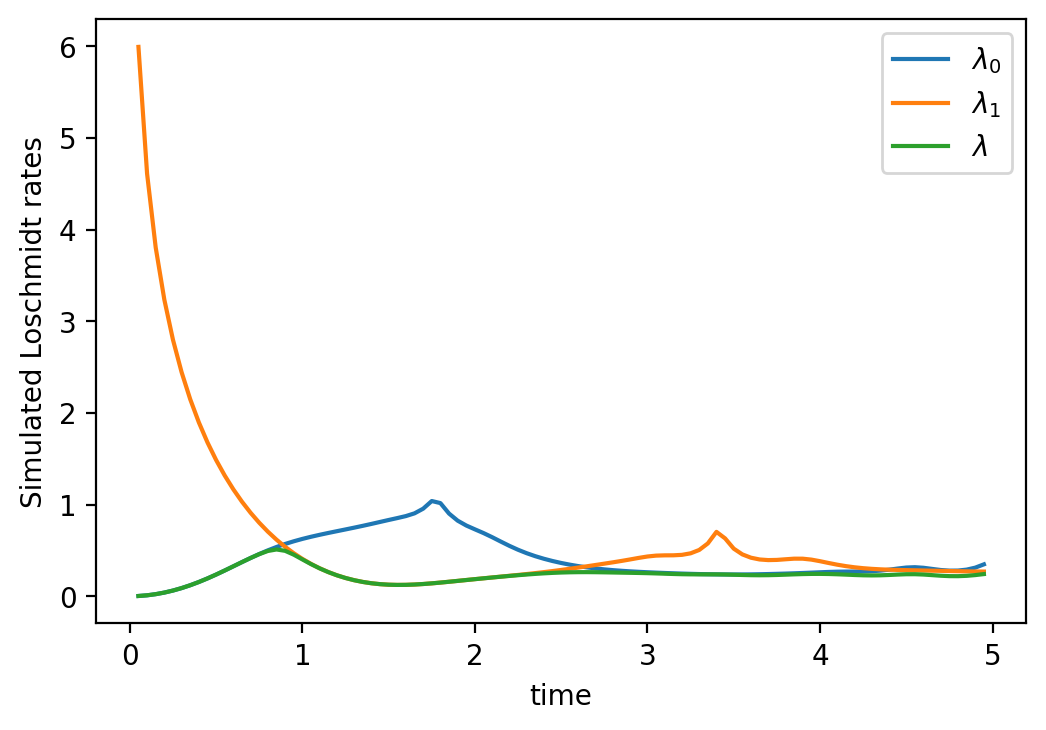

In [41]:
L_12 = np.array([sim_loschmidt(12,2,i,0.05) for i in t])
plt.plot(t, L_12[:,0], label = r"$\lambda_0$")
plt.plot(t, L_12[:,1], label = r"$\lambda_1$")
plt.plot(t, L_12[:,2], label = r"$\lambda$")
plt.legend()
plt.xlabel("time")
plt.ylabel("Simulated Loschmidt rates")
plt.show()

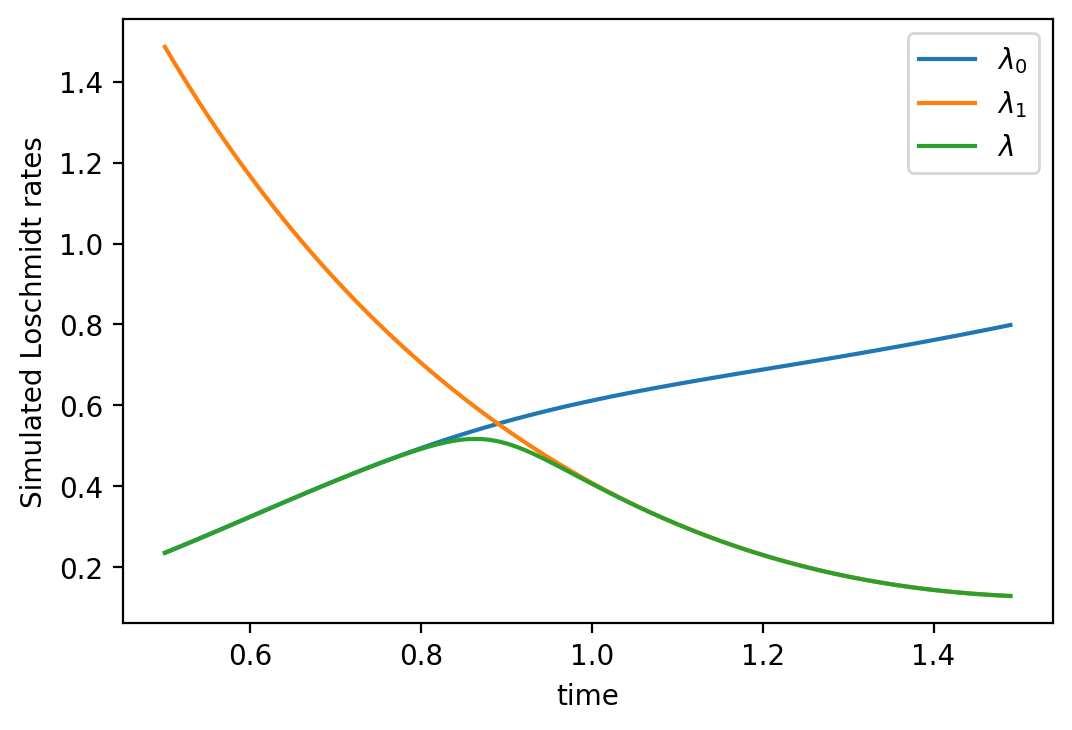

In [42]:
t = arange(0.5,1.5,0.01)
L_16 = np.array([sim_loschmidt(16,2,i,0.01) for i in t])
plt.plot(t, L_16[:,0], label = r"$\lambda_0$")
plt.plot(t, L_16[:,1], label = r"$\lambda_1$")
plt.plot(t, L_16[:,2], label = r"$\lambda$")
plt.legend()
plt.xlabel("time")
plt.ylabel("Simulated Loschmidt rates")
plt.show()

### Exercise 8 b

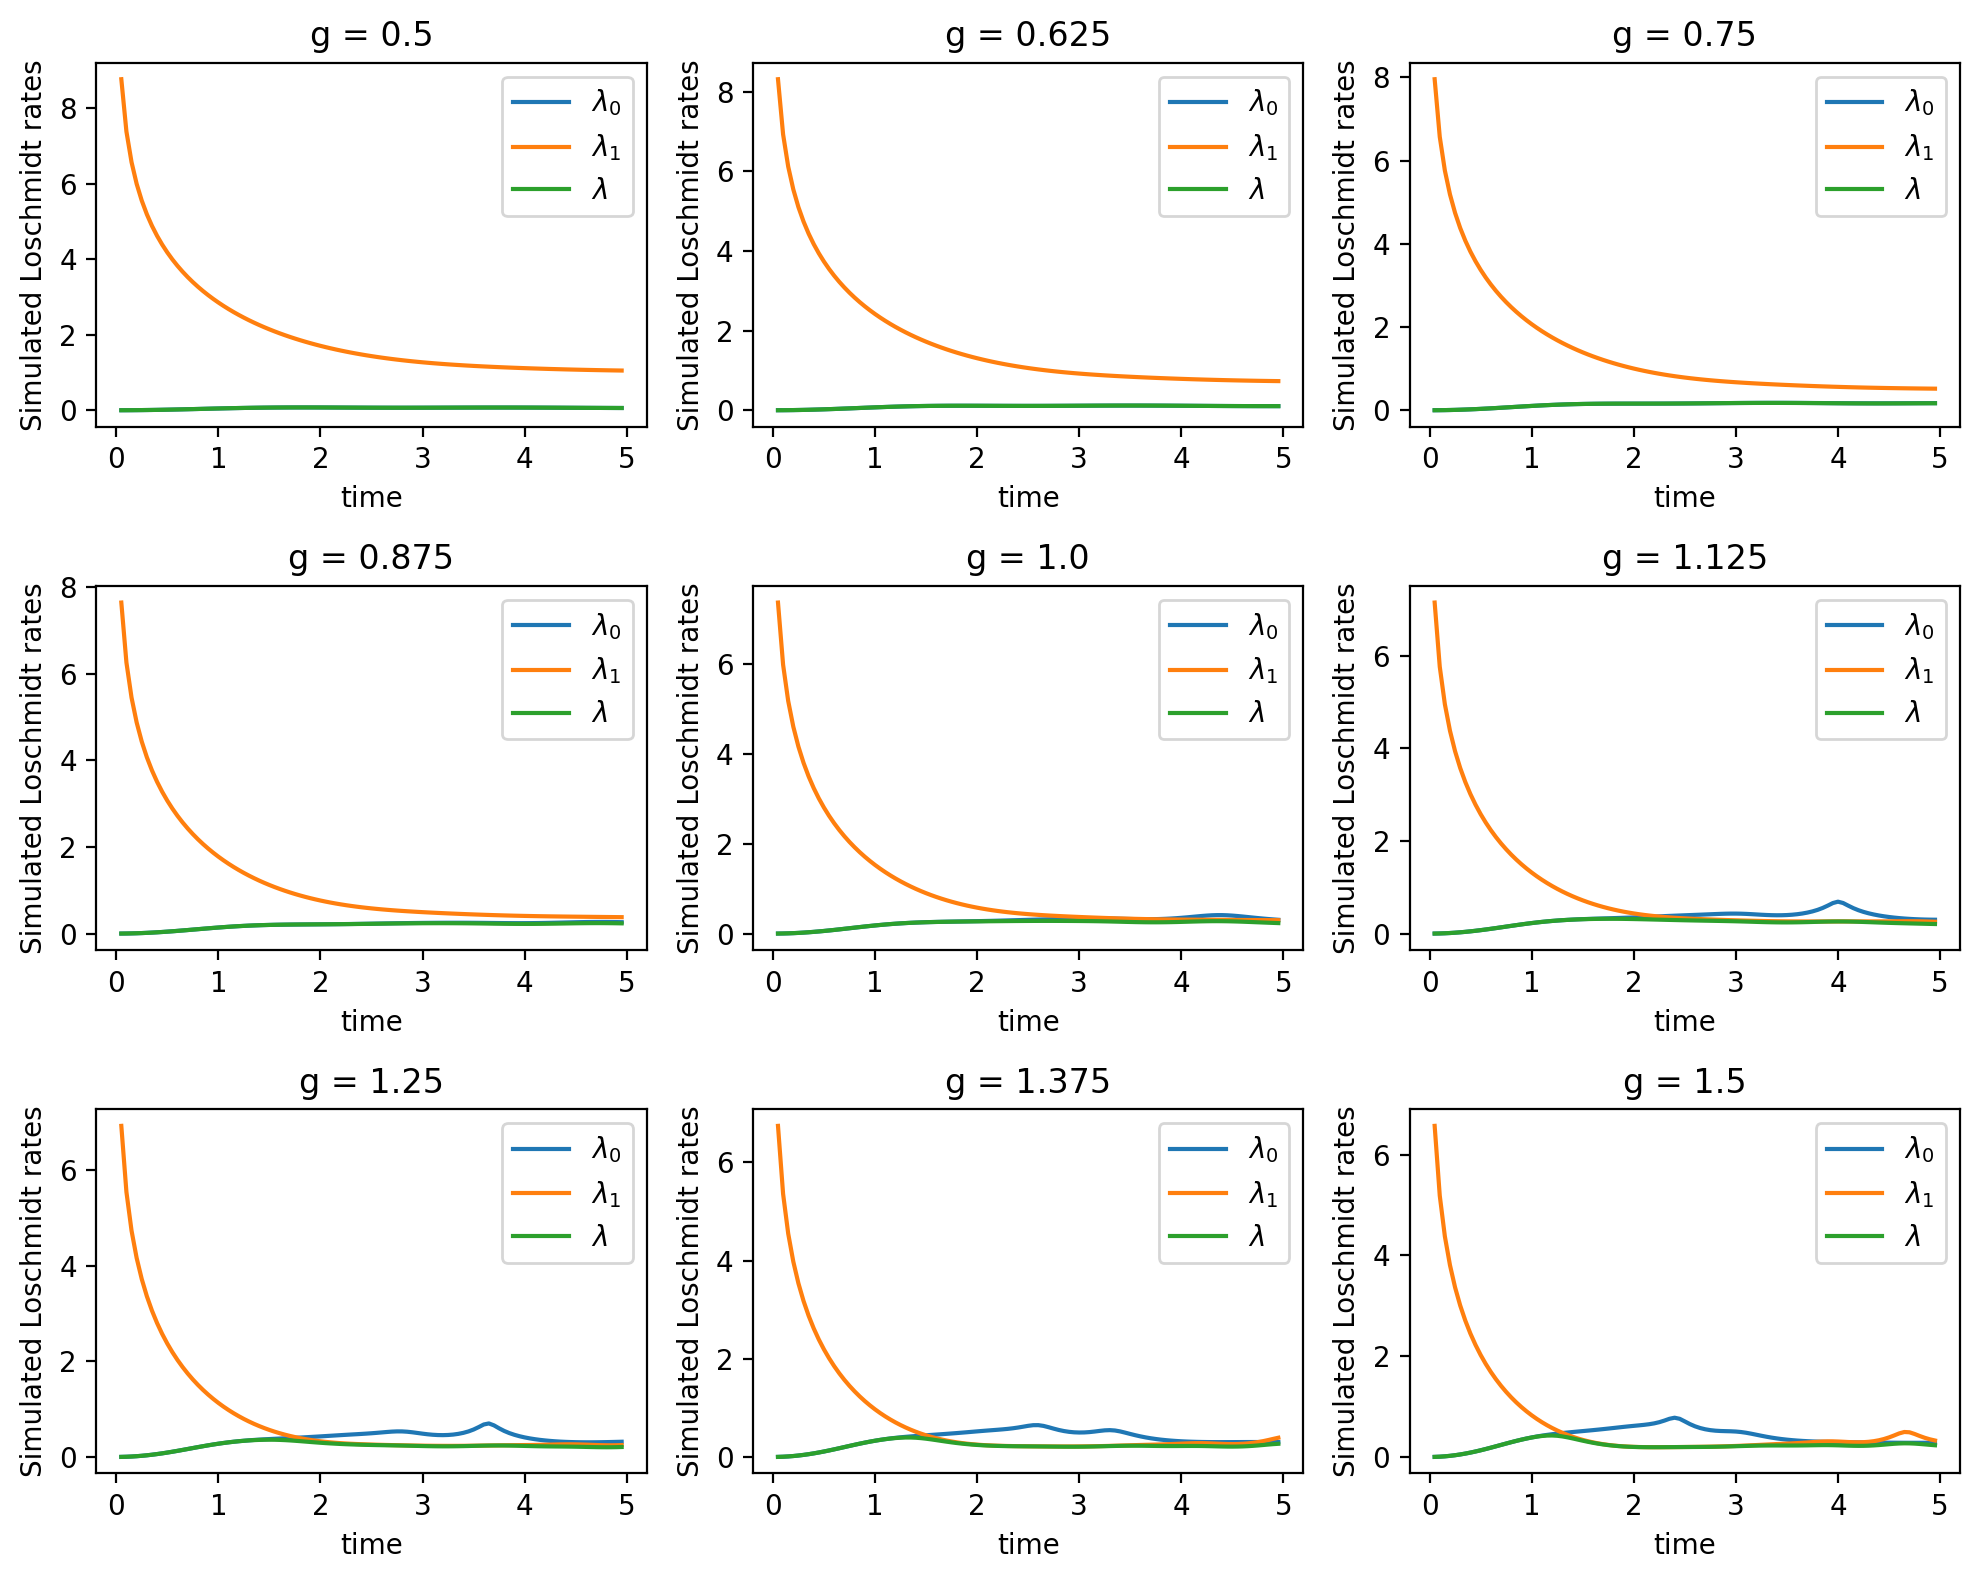

In [27]:
mpl.rcParams['figure.dpi']= 200
t = arange(0.05,5,0.05)
fig, axes = plt.subplots(3, 3, figsize=(10, 8))

### labels
for ax in axes.flat:
    ax.set_xlabel('time')
    ax.set_ylabel('Simulated Loschmidt rates')


tally = 0

for i, ax in enumerate(axes.flat):
    g = 0.5 + 0.125 * tally
    data = np.array([sim_loschmidt(10, g, i, dt) for i in t])
    ax.plot(t, data[:,0], label = r"$\lambda_0$")
    ax.plot(t, data[:,1], label = r"$\lambda_1$")
    ax.plot(t, data[:,2], label = r"$\lambda$")

    
    tally += 1
    ax.set_title('g = ' + str(g))
    ax.legend()

plt.tight_layout()

plt.show()

### Exercise 9

In [44]:
backend = Aer.get_backend("qasm_simulator")

def hw(s):
    ### hamming weight, for extracting magnetization from a string representing measurement counts. 
    downs = [c == '1' for c in s]
    return sum([(-1) ** i for i in downs])

def sim_mag(N, t, dt):
    ### magnetization of psi(t) for psi0 = |0> and the Ising Hamiltonian
    
    ### this one's required measurements is exponential in system size.
    qc = QuantumCircuit(N)
    g = 2
    steps = floor(t/dt)
    for i in range(steps):
        qc = evolve_symmetric(qc, 2, dt)
    qc.measure_all()
    counts = execute(qc, backend, shots = 10000).result().get_counts()
    m_z = 1/10000 * sum([hw(i) * counts.get(i, 0)/N for i in counts.keys()])
    return m_z

def sim_mag_constant(N, t, dt):
    ### magnetization of psi(t) for psi0 = |0> and the Ising Hamiltonian
    
    ### this one only needs constant measurements since we use the symmetry of the problem
    ### and measure only one of the qubits. 
    qc = QuantumCircuit(QuantumRegister(N), ClassicalRegister(1))
    g = 2
    steps = floor(t/dt)
    for i in range(steps):
        qc = evolve_symmetric(qc, 2, dt)
    qc.measure(int(N/2), 0)
    counts = execute(qc, backend, shots = 10000).result().get_counts()
    return (counts.get("0",0) - counts.get("1",0))/10000

def sim_loschmidt_measurements(N, g, t, dt):
    #Loschmidt rate with finite measurements
    qc = QuantumCircuit(N)
    steps = int(np.rint(t/dt))
    for i in range(steps):
        qc = evolve_symmetric(qc, g, dt)
    qc.measure_all()
    counts = execute(qc, backend, shots = 10000).result().get_counts()
    L0, L1 = counts.get("0"*10, 0)/10000, counts.get("1"*10,0)/10000
    L = L0 + L1
    return l(N,L)

In [45]:
L_10_msmt = np.array([sim_loschmidt_measurements(10,2,i,0.05) for i in np.arange(0.05,5,0.05)])

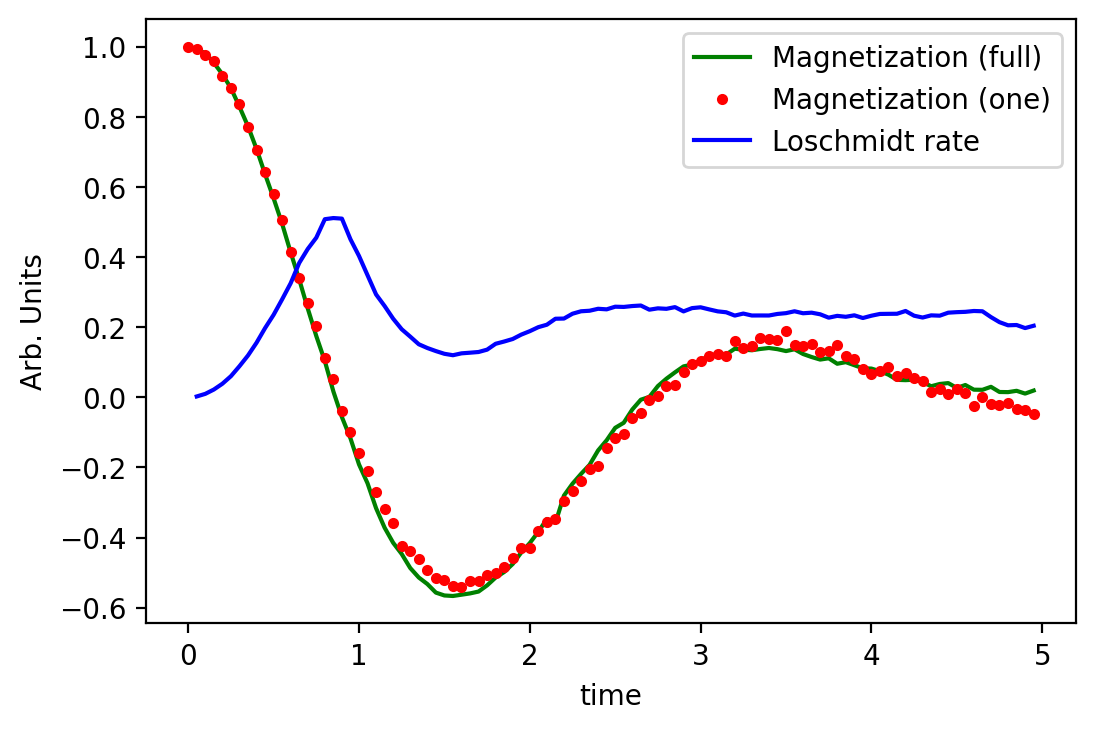

In [46]:
plt.plot(np.arange(0,5,0.05), np.array([sim_mag(10, i * 0.05, 0.05) for i in range(100)]), "g-", label = "Magnetization (full)")
plt.plot(np.arange(0,5,0.05), np.array([sim_mag_constant(10, i * 0.05, 0.05) for i in range(100)]), "r.", label = "Magnetization (one)")
plt.plot(np.arange(0.05,5,0.05), L_10_msmt, "b-", label = "Loschmidt rate")

plt.xlabel("time")
plt.ylabel("Arb. Units")
plt.legend()
plt.show()

### Exercise 11

In [33]:
def S1(rho):
    return entropy(rho, e)

def S2(rho):
    l, v = eig(rho)
    l = [i.real for i in l]
    return -1 * log(sum(i**2 for i in l))

In [34]:
N = 12
g = 2
T = 5
dt = 0.05

backend = Aer.get_backend("statevector_simulator")

def entent(t):
    qc = QuantumCircuit(N)
    steps = int(np.rint(t/dt))
    for i in range(steps):
        qc = evolve_symmetric(qc, 2, dt)
    state = execute(qc, backend).result().get_statevector()
    rho = partial_trace(state, [i for i in range(floor(N/2))])
    return [S1(rho), S2(rho)]


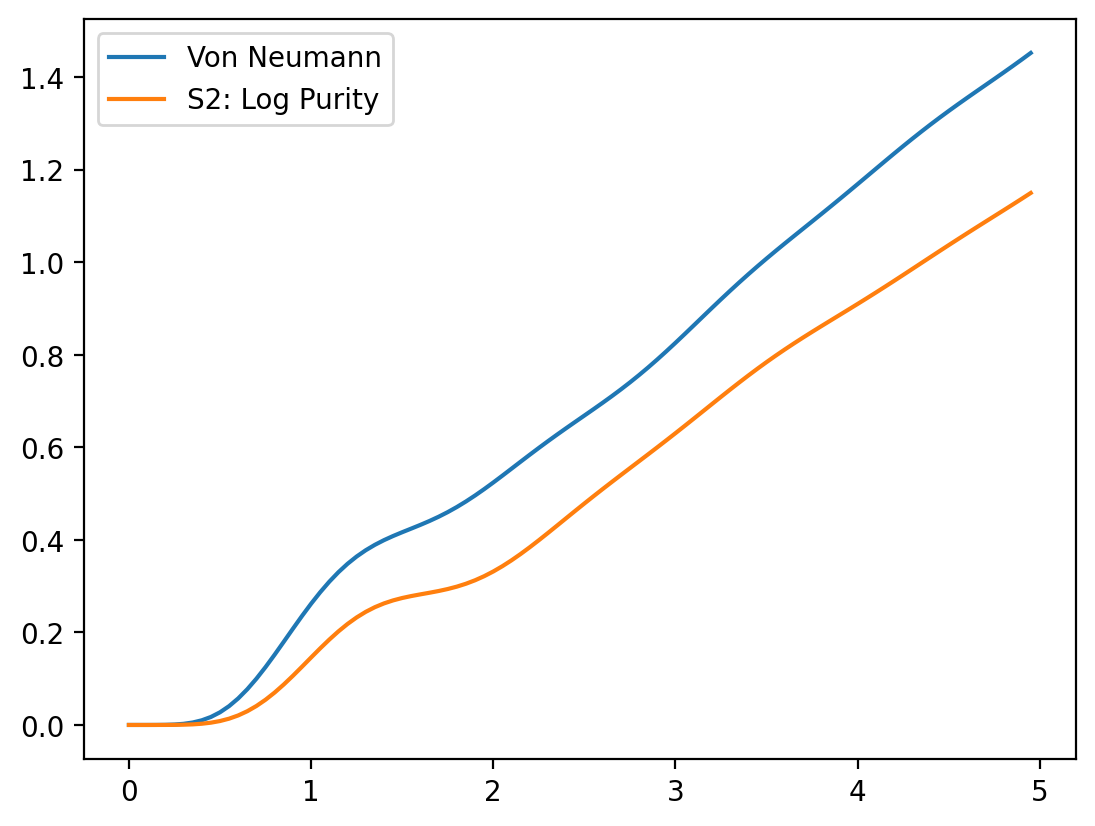

In [35]:
t = arange(0,T,0.05)
entropies = np.array([entent(i) for i in t])
plt.plot(t, entropies[:,0], label = "Von Neumann")
plt.plot(t, entropies[:,1], label = "S2: Log Purity")
plt.legend()
plt.show()

### Problem 13

In [36]:
backend = Aer.get_backend("qasm_simulator")
N = 10
t = 2
g = 2
dt = 1
counts = 2000
trials = 200

def D(a,b):
    return sum(a[i] != b[i] for i in range(len(a)))

In [38]:
def S2_CUE(t):
    return -1 * log2(sum([CUE_ensemble(t) for i in range(trials)])/trials)

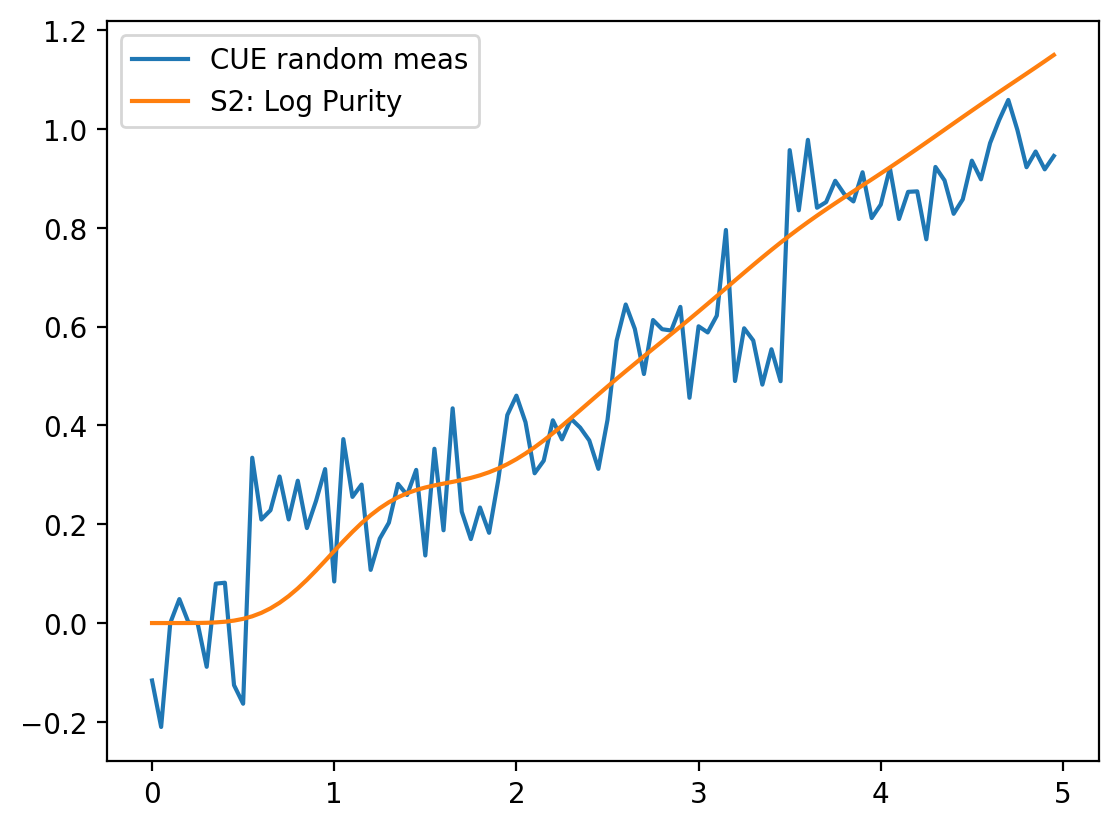

In [40]:
plt.plot(arange(0,5,0.05), [S2_CUE(0.05 * i) for i in range(100)], label = "CUE random meas")
plt.plot(arange(0,5,0.05), entropies[:,1], label = "S2: Log Purity")
plt.legend()
plt.show()